In [38]:
import torch
import torchvision.transforms as tr # 이미지 전처리 기능들을 제공하는 라이브러리
from torch.utils.data import DataLoader, Dataset # 데이터를 모델에 사용할 수 있도록 정리해 주는 라이브러리
import numpy as np # 넘파이 기본 라이브러리
import matplotlib.pyplot as plt

In [39]:
# 32x32 컬러 이미지와 라벨이 각각 100장이 있다고 가정하다.
# glob -> PIL, openCV ..
train_images = np.random.randint(256,size=(100,32,32,3))/255 # (이미지 수)x(너비)x(높이)x(채널 수)
train_labels = np.random.randint(2,size=(100,1)) # 라벨 수

In [40]:
# 커스텀 데이터와 커스텀 전처리 사용하기

# 파이토치는 전처리 함수들을 제공하여 매우 편리하다
# 이미지의 경우 PIL-Image 타입이거나 Tensor 타입일 때만 사용 가능
# 제공하지 않는 기능에 대해 직접 구현 필요

In [41]:
# 커스텀 전처리 직접 정의 및 구현

# 텐서 변환 전처리 클래스 정의
# 전처리는 MyDataset 클래스의 sample 을 불러와 작업하므로 __call__ 이용
# ToTensor 는 입력 데이터를 텐서 데이터로 변환, 학습에 맞는 크리고 변환하는 작업 담당
class ToTensor:
    def __call__(self, sample):
        inputs, labels = sample
        inputs = torch.FloatTensor(inputs) # 텐서 변환
        inputs = inputs.permute(2, 0, 1) # 크기 변환, __call__ 은 입력값을 하나씩 불러오므로 (0, 3, 1, 2) 가 아니다
        return inputs, torch.LongTensor(labels) # 텐서 변환

In [42]:
# 2. 선형식    # 책에 안나옴
class LinearTensor:
    
    def __init__(self, slope=1, bias=0):
        self.slope = slope
        self.bias = bias     
        
    def __call__(self, sample):
        inputs, labels = sample
        inputs = self.slope*inputs + self.bias # ax+b 계산하기
        return inputs, labels 

In [43]:
# 커스텀 전처리 직접 정의 및 구현

# CutOut 전처리 클래스 정의
# 이미지 내부에 무작위로 사각형 영역을 선택하여 0 으로 만드는 데이터 증식 방법

class CutOut:

    # 외부에서 CutOut 발생 비율을 받기 위해 __init__ 함수를 사용하여 ratio 를 받는다.
    # 기본 ratio = 0.5 ; 불러온 이미지에 대해 50% 확률로 CutOut 을 발현한다
    def __init__(self, ratio=.5):
        self.ratio = int(1/ratio)

    # __call__ 메소드는 샘플을 받는다
    def __call__(self, sample):
        inputs, labels = sample
        active = int(np.random.randint(0, self.ratio, 1)) # active 는 정수를 뽑는다. 50% 일 경우 0과 1 중 하나를 뽑는다

        if active == 0: # active = 0 이면 cutout 발현, 0이 아니면 원본 내보냄
            _, w, h = inputs.size() # 이미지의 너비와 높이 받음, 채널 수는 필요없으므로 _ 로 받는다
            min_len = min(w, h) # 너비와 높이의 최소값
            box_size = int(min_len//4) # CutOut 의 크기를 길이의 최소값의 25% 로 설정
            idx = int(np.random.randint(0, min_len - box_size, 1)) # idx를 통해 CutOUt 박스의 좌측 상단 꼭지점 위치를 정한다
            inputs[:,idx:idx + box_size, idx:idx + box_size] = 0 # 해당 정사각형 영엵의 값을 0으로 대체

        return inputs, labels

In [47]:
# 4.3.3 의 Mydataset 에서 전처리 추가

class MyDataset(Dataset):

    def __init__(self, x_data, y_data, transform=None): # __init__ 입력값에 None 추가, transform=None 은 아무 것도 적지 않으면 전처리 사용 X
        self.x_data = x_data
        self.y_data = y_data
        self.transform = transform
        self.len = len(y_data)
        self.tensor = ToTensor()

    def __getitem__(self, index):
        sample = self.x_data[index], self.y_data[index]

        if self.transform: # 만약 transform 이 None 이 아니라면 __getitme__ 에서 sample을 반환하기 전에 전처리를 할 수 있도록 if문 작성
            sample = self.transform(sample)
        else:
            sample = self.tensor(sample)  # transform=None 일 경우 텐서 변환을 기본적으로 하도록 구성
        return sample

    def __len__(self):
        return self.len

In [48]:
# 직접 만든 ToTensor()를 사용, CutOut 은 괄호() 에 아무것도 없으므로 발현 비율 기본값인 0.5로 CutOut 시행
trans = tr.Compose([ToTensor(), CutOut()])

# 정의된 전처리를 입력한 데이터 세트로 만들고 DataLoader 사용
dataset1 = MyDataset(train_images, train_labels, transform=trans)
train_loader1 = DataLoader(dataset1, batch_size=10, shuffle=True)

In [52]:
images1, labels1 = iter(train_loader1).next() # iter, next로 첫 번째 배치를 불러와 결과 확인
print(images1.size()) # 배치 및 이미지 크기 확인

torch.Size([10, 3, 32, 32])


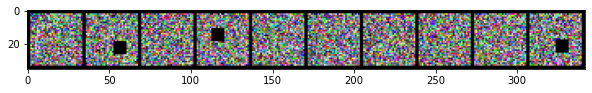

In [53]:
import torchvision # 그리드를 만들어주는 torchvision.utils.make_grid를 사용하기 위해 torchvision 불러온다

def imshow(img):
    plt.figure(figsize=(10, 100))
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.show()

imshow(torchvision.utils.make_grid(images1, nrow=10))

In [54]:
# 커스텀 데이터와 파이토치 제공 전처리 사용하기

# 텐서 변환과 같은 전처리는 파이토치에서 사용하는 전처리를 사용하면 편리하다
# 파이토치 전처리는 PILImage 타입만 사용할 수 있다
# 데이터 타입이 다른 경우 PILImage 타입으로 변환하여 제공된 전처리를 사용 가능

In [55]:
class Mytransform: # 전처리 클래스 MyTransform 을 정의하여 원하는 전처리 작성

    def __call__(self, sample):
        inputs, labels = sample
        inputs = torch.FloatTensor(inputs)
        inputs = inputs.permute(2, 0, 1)
        labels = torch.FloatTensor(labels)

        transf = tr.Compose([tr.ToPILImage(), tr.Resize(128), tr.ToTensor()]) # tr.Compose 는 차례대로 전처리 작업을 하므로 가장 첫 번쨰에 tr.ToPILImage() 를 넣어 이미지 타입 변환
        final_output = transf(inputs) # 다음 불러온 샘플을 전처리 작업에 넣어준다

        return final_output, labels

In [56]:
dataset2 = MyDataset(train_images, train_labels, transform=Mytransform()) # Mydataset 은 4.3.4와 동일하게 사용하고 전처리에 MyTransform() 을 넣어준다
train_loader2 = DataLoader(dataset2, batch_size=10, shuffle=True)

In [ ]:
# 커스텀 전처리와 파이토치에서 제공하는 전처리 함께 사용하기

# 4.3.4 에서 사용한 CutOut 과 달리 아래 CutOut 은 라벨은 받지 않고 이미지만 받아 처리하도록 세팅한다.
# Compose 내부에 있는 제공된 전처리는 이미지만 받아서 처리하기 때문
# 위에서 만든 CutOut 은 텐서나 넘파이 배열 모두 작동을 하게 만들었지만 PILImage 타입에서는 타입 오류 발생
# 따라서 tr.ToTensor() 뒤에 CutOut 배치

In [57]:
class CutOut:

    def __init__(self, ratio=.5):
        self.ratio = int(1/ratio)

    def __call__(self, inputs):
        active = int(np.random.randint(0, self.ratio, 1))

        if active == 0:
            _, w, h = inputs.size()
            min_len = min(w, h)
            box_size= int(min_len//4)
            idx = int(np.random.randint(0, min_len - box_size, 1))
            inputs[:,idx:idx+box_size,idx:idx+box_size] = 0

        return inputs


transf = tr.Compose([tr.Resize(128), tr.ToTensor(), CutOut()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transf)

Files already downloaded and verified


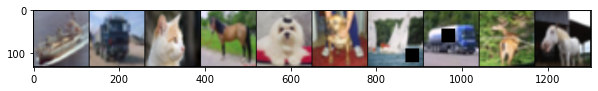

torch.Size([10, 3, 128, 128])


In [58]:
# 다음 결과를 통해 CIFAR10 데이터가 배치 10개씩 나눠지고 이미지 사이즈를 128로 늘린 뒤 텐서로 변환되고 50% 의 확률로 무작위 선택하여 CutOut 적용
trainloader = DataLoader(trainset, batch_size=10, shuffle=True)
images, labels = iter(trainloader).next()
imshow(torchvision.utils.make_grid(images, nrow=10))
print(images.size()) # 배치 및 이미지 크기 확인